In [4]:
#Important Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from google.colab import drive
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
# Loaded dataset
drive.mount('/content/drive')
file = '/content/drive/MyDrive/sales_data_sample.csv'
df = pd.read_csv(file, encoding='latin1')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:

# Dropping unnecessary columns
columns_to_drop = [
    'ADDRESSLINE1', 'ADDRESSLINE2', 'STATE', 'TERRITORY', 'PRODUCTLINE',
    'CUSTOMERNAME', 'COUNTRY', 'CITY', 'STATUS', 'QTR_ID', 'PHONE'
]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True, errors='ignore')
df.dropna(inplace=True)

# Parse dates
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df['YEAR'] = df['ORDERDATE'].dt.year
df['MONTH'] = df['ORDERDATE'].dt.month

# Group by month
monthly_sales = df.groupby(['YEAR', 'MONTH'])['SALES'].sum().reset_index()
monthly_sales['ORDERDATE'] = pd.to_datetime(monthly_sales[['YEAR', 'MONTH']].assign(DAY=1))
monthly_sales.sort_values('ORDERDATE', inplace=True)

# Prepare for Prophet
prophet_data = monthly_sales[['ORDERDATE', 'SALES']].rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'})

# Train/test split (last 6 months for testing)
train = prophet_data.iloc[:-6]
test = prophet_data.iloc[-6:]

# Prophet model
# Build Prophet model
model = Prophet( yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model.fit(train)

# Forecast test period
future = model.make_future_dataframe(periods=6, freq='MS')
forecast = model.predict(future)

# Compare predictions with actuals
predicted = forecast[['ds', 'yhat']].set_index('ds').join(test.set_index('ds'))
predicted.dropna(inplace=True)

# Calculate metrics
mae = mean_absolute_error(predicted['y'], predicted['yhat'])
rmse = np.sqrt(mean_squared_error(predicted['y'], predicted['yhat']))
mape = np.mean(np.abs((predicted['y'] - predicted['yhat']) / predicted['y'])) * 100

# Forecast full 12 months
future_full = model.make_future_dataframe(periods=12, freq='MS')
forecast_full = model.predict(future_full)

# Merge with actuals
results = forecast_full[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(
    prophet_data.rename(columns={'y': 'actual'}), on='ds', how='left'
)



INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5i86vne2/r06xgdrz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5i86vne2/j5uyf5dg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59438', 'data', 'file=/tmp/tmp5i86vne2/r06xgdrz.json', 'init=/tmp/tmp5i86vne2/j5uyf5dg.json', 'output', 'file=/tmp/tmp5i86vne2/prophet_modelyv95txo7/prophet_model-20250606092107.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:21:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


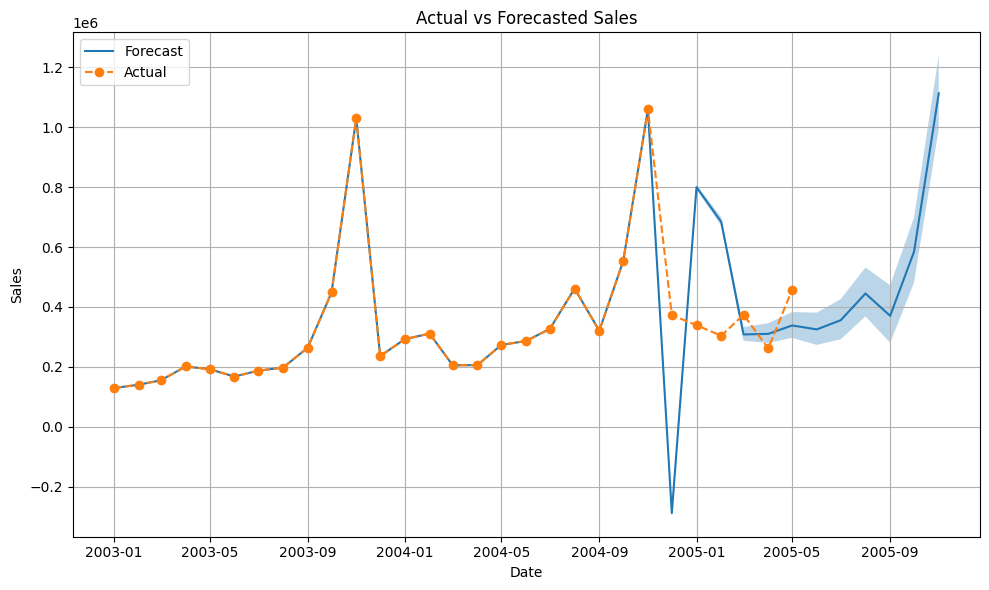

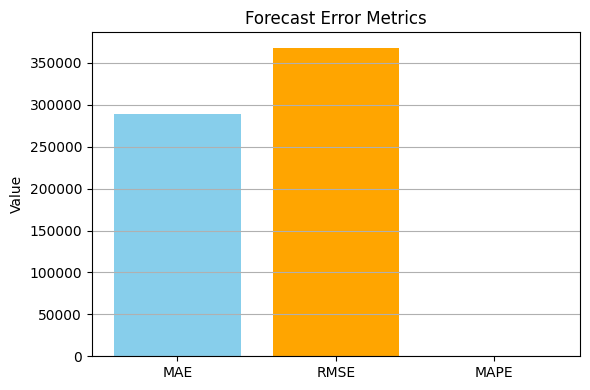

MAE  = 288,987.82
RMSE = 367,996.82
MAPE = 83.30%


In [12]:
# Plot forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(results['ds'], results['yhat'], label='Forecast')
plt.plot(results['ds'], results['actual'], label='Actual', linestyle='dashed', marker='o')
plt.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'], alpha=0.3)
plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot error metrics
metrics = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE'],
    'Value': [mae, rmse, mape]
})

plt.figure(figsize=(6, 4))
plt.bar(metrics['Metric'], metrics['Value'], color=['skyblue', 'orange', 'lightgreen'])
plt.title('Forecast Error Metrics')
plt.ylabel('Value')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
print(f"MAE  = {mae:,.2f}")
print(f"RMSE = {rmse:,.2f}")
print(f"MAPE = {mape:.2f}%")

results.to_csv('/content/drive/MyDrive/forecast_results.csv', index=False)
metrics.to_csv('/content/drive/MyDrive/forecast_metrics.csv', index=False)
